# Notebook 07: Reporting and Publication Tools

**New in v0.10.0**: Comprehensive reporting tools for generating publication-ready analysis

This notebook demonstrates:
1. Creating comprehensive model reports
2. Generating summary statistics and evaluation metrics
3. Exporting to multiple formats (Markdown, LaTeX, figures)
4. Comparing multiple models
5. Creating publication-quality visualizations

**Use Case**: Preparing results for academic papers, reports, or presentations

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from epydemics import DataContainer, Model
from epydemics.analysis import ModelReport, create_comparison_report

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Epydemics v0.10.0 - Reporting Tools Demo")
print("="*60)

Epydemics v0.10.0 - Reporting Tools Demo


## 1. Prepare Sample Data

Using realistic measles data (annual incidence)

Mexico Measles Data (2010-2024)
              I  D          N
2010-12-31  220  1  120000000
2011-12-31   55  1  122000000
2012-12-31  667  3  124000000
2013-12-31  164  4  126000000
2014-12-31   81  4  128000000
2015-12-31   34  4  130000000
2016-12-31   12  4  132000000
2017-12-31    0  4  134000000
2018-12-31    0  4  136000000
2019-12-31    4  4  138000000
2020-12-31   18  4  140000000
2021-12-31   45  5  142000000
2022-12-31  103  7  144000000
2023-12-31   67  8  146000000
2024-12-31   89  9  148000000


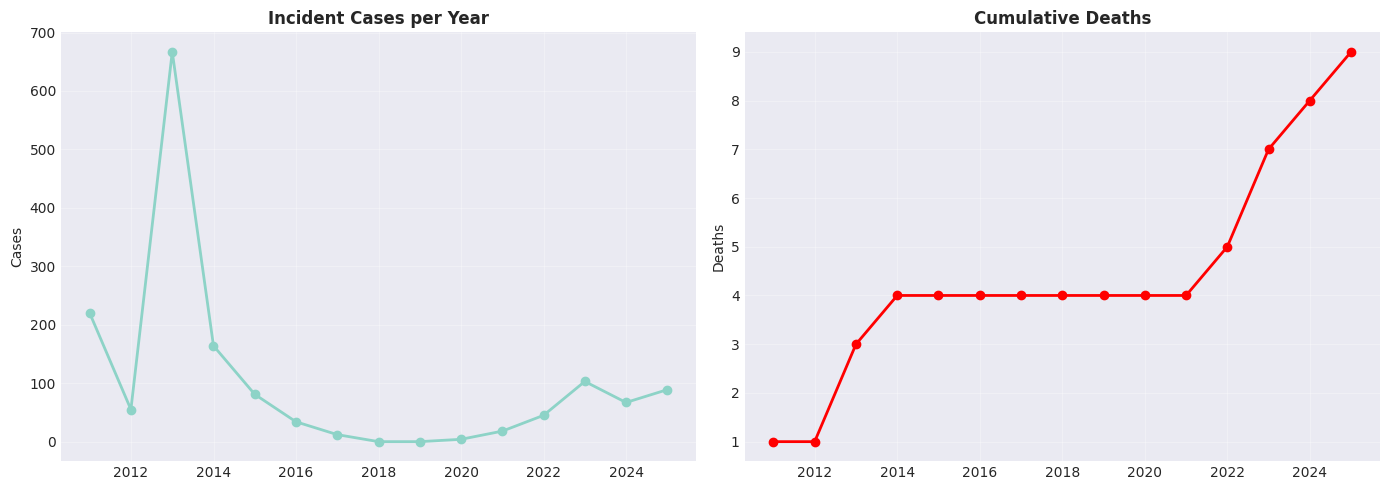


Data characteristics:
  Total cases: 1559
  Total deaths: 9
  Case Fatality Rate: 0.58%


In [2]:
# Create realistic measles data (Mexico 2010-2024)
np.random.seed(42)
dates = pd.date_range('2010', periods=15, freq='YE')

# Incident cases per year (realistic pattern)
incident_cases = np.array([
    220, 55, 667, 164, 81,   # 2010-2014: sporadic
    34, 12, 0, 0, 4,         # 2015-2019: near elimination
    18, 45, 103, 67, 89      # 2020-2024: reintroduction
])

# Cumulative deaths (CFR ~0.1%)
incident_deaths = np.array([1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1])
cumulative_deaths = np.cumsum(incident_deaths)

# Population
population = [120_000_000 + i*2_000_000 for i in range(15)]

# Create DataFrame
data = pd.DataFrame({
    'I': incident_cases,
    'D': cumulative_deaths,
    'N': population
}, index=dates)

print("Mexico Measles Data (2010-2024)")
print(data)

# Visualize the pattern
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(data.index, data['I'], 'o-', linewidth=2, markersize=6)
ax1.set_title('Incident Cases per Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cases')
ax1.grid(True, alpha=0.3)

ax2.plot(data.index, data['D'], 'o-', linewidth=2, markersize=6, color='red')
ax2.set_title('Cumulative Deaths', fontsize=12, fontweight='bold')
ax2.set_ylabel('Deaths')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nData characteristics:")
print(f"  Total cases: {incident_cases.sum()}")
print(f"  Total deaths: {cumulative_deaths[-1]}")
print(f"  Case Fatality Rate: {cumulative_deaths[-1]/incident_cases.sum()*100:.2f}%")

## 2. Split Data and Train Model

Train on 2010-2019, test on 2020-2024

In [3]:
# Split train/test
train_data = data.iloc[:10]  # 2010-2019 (10 years)
test_data = data.iloc[10:]   # 2020-2024 (5 years)

print(f"Training data: {train_data.index[0].year} - {train_data.index[-1].year} ({len(train_data)} years)")
print(f"Testing data:  {test_data.index[0].year} - {test_data.index[-1].year} ({len(test_data)} years)")

# Create model with incidence mode
container = DataContainer(train_data, mode='incidence', window=3)
model = Model(container)

print(f"\nModel mode: {model.mode}")
print(f"Frequency: {container.frequency}")

# Fit and forecast
model.create_model()
model.fit_model(max_lag=2)
model.forecast(steps=5)  # Forecast 5 years
model.run_simulations(n_jobs=1)
model.generate_result()

print("\n✅ Model fitted and forecast generated!")

2025-12-24 17:03:03,746 - root - INFO - Auto-detected frequency: YE
2025-12-24 17:03:03,747 - root - INFO - Using AnnualFrequencyHandler for YE frequency
2025-12-24 17:03:03,750 - root - INFO - Preserving native YE frequency (skipping reindexing)
2025-12-24 17:03:03,753 - root - INFO - No vaccination data detected. Using SIRD model.
2025-12-24 17:03:03,782 - root - INFO - Model initialized with 3 rates (SIRD mode), forecaster='var'
2025-12-24 17:03:03,783 - root - INFO - Forecasting orchestrator initialized: backend='var', 3 rates (SIRD (3-rate))
2025-12-24 17:03:03,784 - root - WARNING - Detected constant columns: [0]. VAR fitting will use trend='n' to avoid conflicts.
2025-12-24 17:03:03,784 - root - WARNING - Reduced max_lag from 2 to 1 due to limited observations (10)
2025-12-24 17:03:03,785 - root - INFO - Using trend='n' (no trend) due to constant columns
2025-12-24 17:03:03,794 - root - INFO - Simulation initialized without vaccination (SIRD mode)
2025-12-24 17:03:03,795 - root 

Training data: 2010 - 2019 (10 years)
Testing data:  2020 - 2024 (5 years)

Model mode: incidence
Frequency: YE

✅ Model fitted and forecast generated!


## 3. Create ModelReport

The `ModelReport` class provides a high-level interface for analyzing results

In [4]:
# Create comprehensive report
report = ModelReport(
    results=model.results,
    testing_data=test_data,
    compartments=['I', 'D'],
    model_name="Mexico Measles Forecast (2010-2024)"
)

# Store historical data for visualization
report.historical_data = train_data

print("✅ ModelReport created")
print(f"   Compartments: {report.compartments}")
print(f"   Has test data: {report.testing_data is not None}")
print(f"   Has historical data: {hasattr(report, 'historical_data')}")

✅ ModelReport created
   Compartments: ['I', 'D']
   Has test data: True
   Has historical data: True


## 4. Generate Summary Statistics

Get comprehensive statistics for all compartments

In [5]:
summary_df = report.generate_summary()

print("Summary Statistics:")
print("="*80)
display(summary_df)

print("\n📊 Key Insights:")
for _, row in summary_df.iterrows():
    print(f"  {row['Compartment']}:")
    print(f"    Mean forecast: {row['Mean']:.1f}")
    print(f"    Range: {row['Min']:.1f} - {row['Max']:.1f}")
    print(f"    Coefficient of Variation: {row['CV (%)']:.1f}%")

Summary Statistics:


,Compartment,Code,Mean,Median,Std Dev,Min,Max,Range,CV (%)
0,Infected,I,20.485077,12.680068,14.197054,7.846575,43.124261,35.277686,69.304372
1,Deaths,D,5.742301,4.000000,1.908536,4.000000,8.444244,4.444244,33.236435



📊 Key Insights:
  Infected:
    Mean forecast: 20.5
    Range: 7.8 - 43.1
    Coefficient of Variation: 69.3%
  Deaths:
    Mean forecast: 5.7
    Range: 4.0 - 8.4
    Coefficient of Variation: 33.2%


## 5. Evaluate Forecast Accuracy

Compare forecasts against test data with multiple metrics

In [6]:
eval_df = report.get_evaluation_summary()

print("Forecast Evaluation Metrics:")
print("="*80)
display(eval_df)

# Highlight best performing method
for comp in ['I', 'D']:
    comp_eval = eval_df[eval_df['Compartment'].str.contains(comp)]
    best_mae = comp_eval.loc[comp_eval['MAE'].idxmin()]
    print(f"\n🏆 Best method for {comp}: {best_mae['Method']} (MAE: {best_mae['MAE']:.2f})")

Forecast Evaluation Metrics:


,Compartment,Method,MAE,RMSE,MAPE (%),SMAPE (%)
0,Infected,Mean,43.914923,50.576356,66.235440,50.845845
1,Infected,Median,51.719932,58.762614,75.935372,62.312621
2,Infected,Gmean,50.962392,57.955799,74.840640,60.803352
3,Infected,Hmean,54.545327,62.078329,79.276973,67.222950
4,Deaths,Mean,0.857699,1.010297,12.612999,6.939653
5,Deaths,Median,2.600000,3.193744,33.682538,22.035741
6,Deaths,Gmean,1.603343,1.885686,21.456077,12.441107
7,Deaths,Hmean,1.959835,2.366601,25.740369,15.545817



🏆 Best method for I: Mean (MAE: 43.91)

🏆 Best method for D: Mean (MAE: 0.86)


## 6. Create Multi-Panel Visualization

Generate publication-quality figures with all compartments

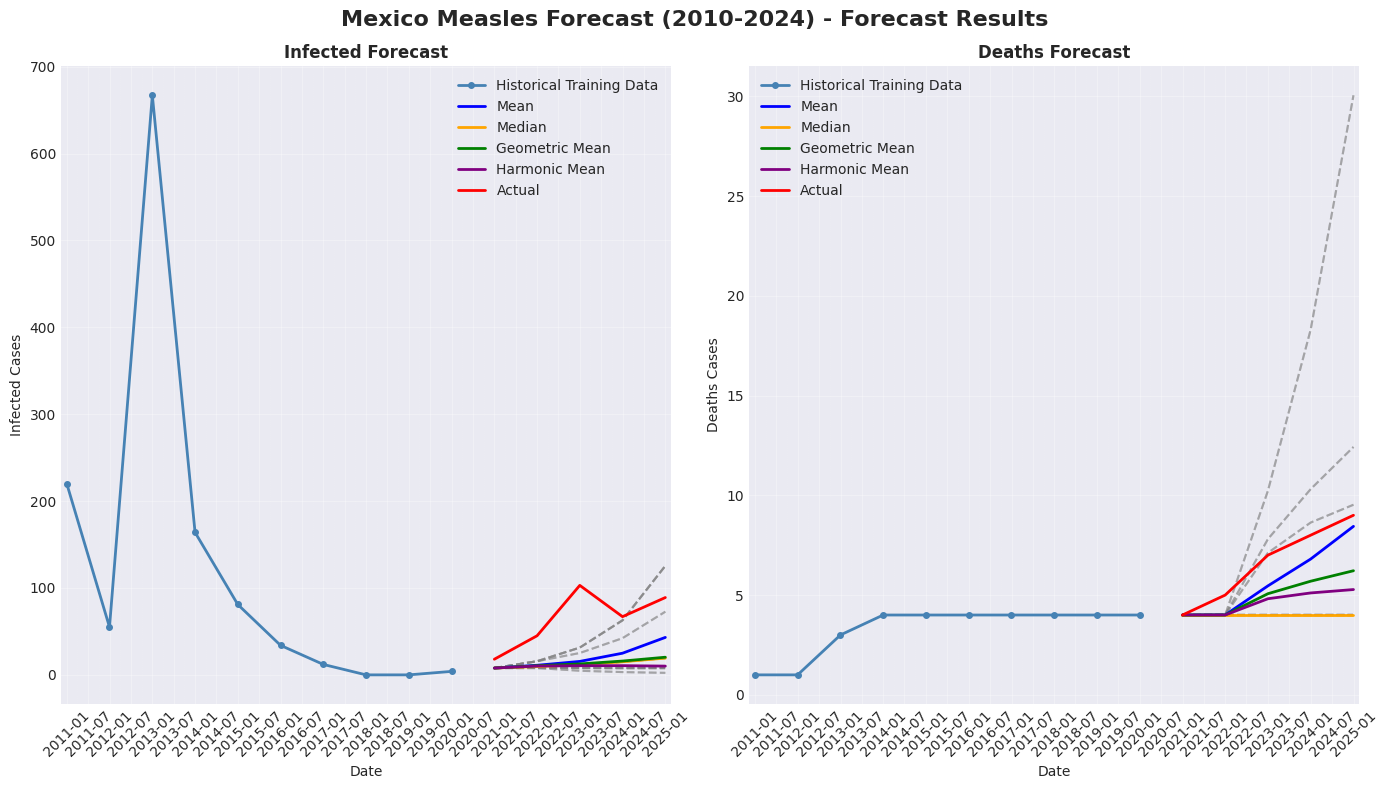


💡 Tip: Set save_path='output.png' and dpi=600 for publication quality!


In [7]:
fig = report.plot_forecast_panel(
    figsize=(14, 8),
    save_path=None  # Don't save yet, just display
)

plt.show()

print("\n💡 Tip: Set save_path='output.png' and dpi=600 for publication quality!")

## 7. Export Reports

Generate reports in multiple formats for different purposes

Figure saved to notebook_outputs/reporting_demo/measles_report_forecast.png
Report exported to notebook_outputs/reporting_demo/measles_report.md
✅ Markdown report: notebook_outputs/reporting_demo/measles_report.md
LaTeX table exported to notebook_outputs/reporting_demo/table1_summary.tex
✅ LaTeX summary table: notebook_outputs/reporting_demo/table1_summary.tex
LaTeX table exported to notebook_outputs/reporting_demo/table2_evaluation.tex
✅ LaTeX evaluation table: notebook_outputs/reporting_demo/table2_evaluation.tex
Figure saved to notebook_outputs/reporting_demo/figure1_forecast.png
✅ High-res figure: notebook_outputs/reporting_demo/figure1_forecast.png

📁 All outputs saved to: notebook_outputs/reporting_demo


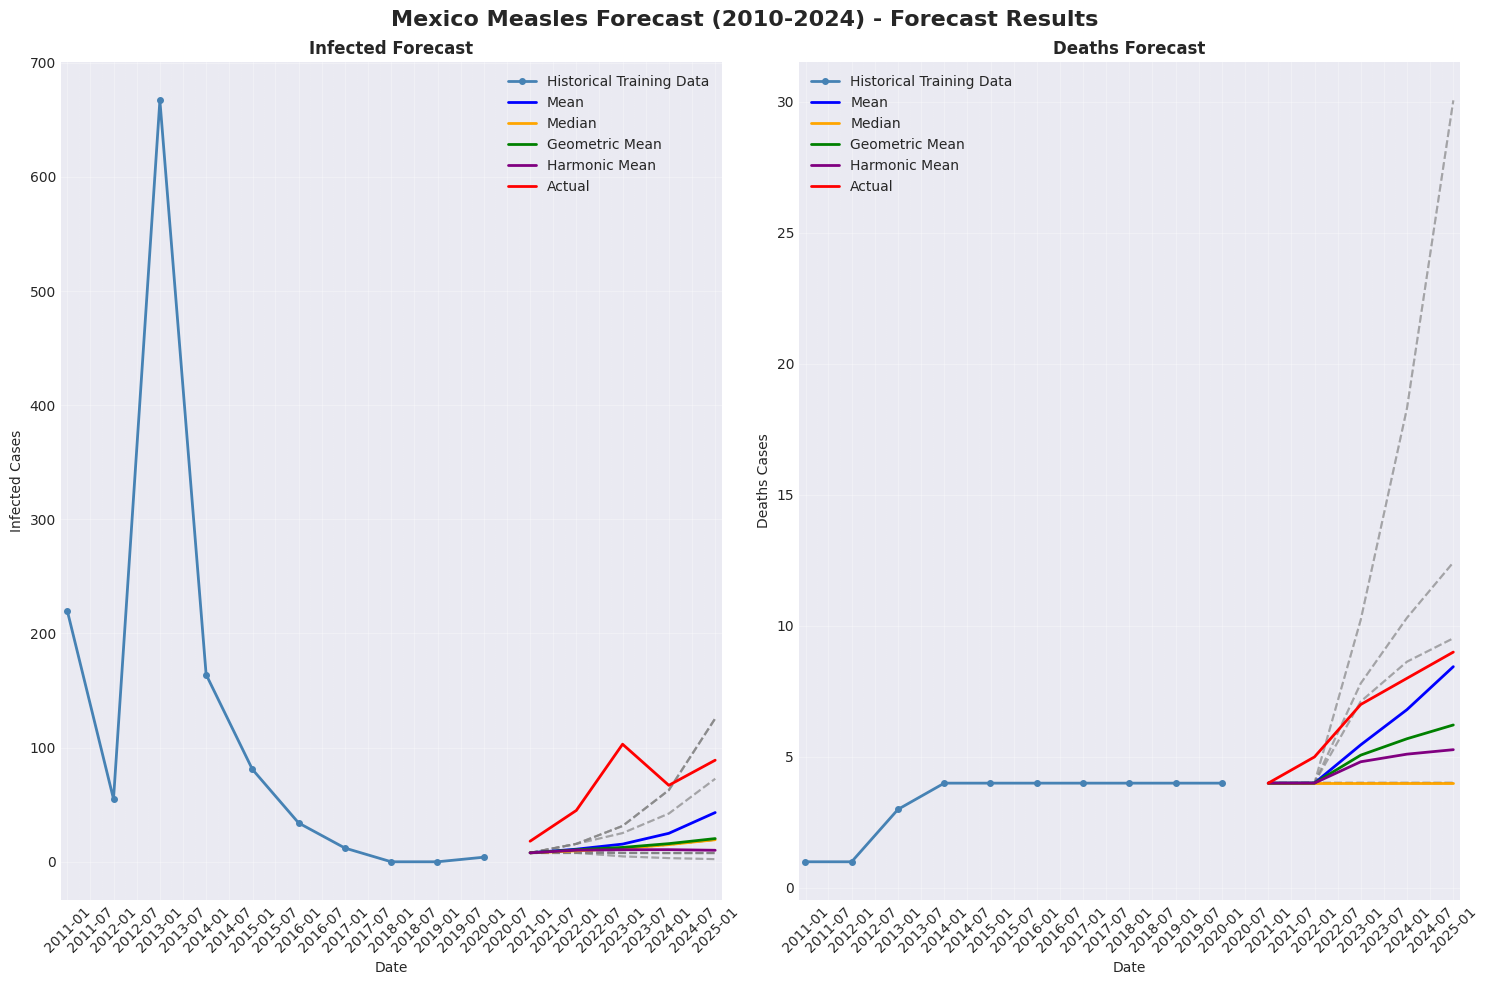

In [8]:
# Create output directory
output_dir = Path("notebook_outputs/reporting_demo")
output_dir.mkdir(parents=True, exist_ok=True)

# 1. Markdown report (for GitHub, documentation)
report.export_markdown(
    filepath=output_dir / "measles_report.md",
    include_summary=True,
    include_evaluation=True,
    include_figure=True
)
print(f"✅ Markdown report: {output_dir / 'measles_report.md'}")

# 2. LaTeX tables (for academic papers)
report.export_latex_table(
    filepath=output_dir / "table1_summary.tex",
    table_type="summary"
)
print(f"✅ LaTeX summary table: {output_dir / 'table1_summary.tex'}")

report.export_latex_table(
    filepath=output_dir / "table2_evaluation.tex",
    table_type="evaluation"
)
print(f"✅ LaTeX evaluation table: {output_dir / 'table2_evaluation.tex'}")

# 3. High-resolution figure (for publications)
fig_pub = report.plot_forecast_panel(
    figsize=(14, 10),
    save_path=output_dir / "figure1_forecast.png",
    dpi=300  # Use 600 for journal submission
)
plt.close(fig_pub)
print(f"✅ High-res figure: {output_dir / 'figure1_forecast.png'}")

print(f"\n📁 All outputs saved to: {output_dir}")

## 8. Preview Generated Markdown Report

In [9]:
# Display the generated Markdown report
with open(output_dir / "measles_report.md", 'r') as f:
    markdown_content = f.read()

from IPython.display import Markdown
display(Markdown(markdown_content))

# Mexico Measles Forecast (2010-2024) - Forecast Report

**Generated**: 2025-12-24 17:03:05

---

## Summary Statistics

| Compartment   | Code   |    Mean |   Median |   Std Dev |     Min |      Max |    Range |   CV (%) |
|:--------------|:-------|--------:|---------:|----------:|--------:|---------:|---------:|---------:|
| Infected      | I      | 20.4851 |  12.6801 |  14.1971  | 7.84658 | 43.1243  | 35.2777  |  69.3044 |
| Deaths        | D      |  5.7423 |   4      |   1.90854 | 4       |  8.44424 |  4.44424 |  33.2364 |


## Forecast Evaluation

| Compartment   | Method   |       MAE |     RMSE |   MAPE (%) |   SMAPE (%) |
|:--------------|:---------|----------:|---------:|-----------:|------------:|
| Infected      | Mean     | 43.9149   | 50.5764  |    66.2354 |    50.8458  |
| Infected      | Median   | 51.7199   | 58.7626  |    75.9354 |    62.3126  |
| Infected      | Gmean    | 50.9624   | 57.9558  |    74.8406 |    60.8034  |
| Infected      | Hmean    | 54.5453   | 62.0783  |    79.277  |    67.223   |
| Deaths        | Mean     |  0.857699 |  1.0103  |    12.613  |     6.93965 |
| Deaths        | Median   |  2.6      |  3.19374 |    33.6825 |    22.0357  |
| Deaths        | Gmean    |  1.60334  |  1.88569 |    21.4561 |    12.4411  |
| Deaths        | Hmean    |  1.95984  |  2.3666  |    25.7404 |    15.5458  |


## Forecast Visualization

![Forecast Results](measles_report_forecast.png)


## 9. Model Comparison

Compare different model configurations side-by-side

2025-12-24 17:03:11,943 - root - INFO - Auto-detected frequency: YE
2025-12-24 17:03:11,944 - root - INFO - Using AnnualFrequencyHandler for YE frequency
2025-12-24 17:03:11,946 - root - INFO - Preserving native YE frequency (skipping reindexing)
2025-12-24 17:03:11,947 - root - INFO - No vaccination data detected. Using SIRD model.
2025-12-24 17:03:11,971 - root - INFO - Model initialized with 3 rates (SIRD mode), forecaster='var'
2025-12-24 17:03:11,972 - root - INFO - Forecasting orchestrator initialized: backend='var', 3 rates (SIRD (3-rate))
2025-12-24 17:03:11,974 - root - WARNING - Detected constant columns: [0]. VAR fitting will use trend='n' to avoid conflicts.
2025-12-24 17:03:11,975 - root - WARNING - Reduced max_lag from 2 to 1 due to limited observations (10)
2025-12-24 17:03:11,979 - root - INFO - Using trend='n' (no trend) due to constant columns
2025-12-24 17:03:12,009 - root - INFO - Simulation initialized without vaccination (SIRD mode)
2025-12-24 17:03:12,011 - root 

✅ Created 3 models with different smoothing windows


2025-12-24 17:03:13,112 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03:14,338 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03:14,654 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03:14,967 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03:15,027 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03:15,145 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03

Comparison figure saved to notebook_outputs/reporting_demo/model_comparison.png


2025-12-24 17:03:18,723 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03:18,902 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03:19,034 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03:19,093 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03:19,231 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03:19,448 - matplotlib.ticker - WARNING - Locator attempting to generate 1863 ticks ([18244.0, ..., 20106.0]), which exceeds Locator.MAXTICKS (1000).
2025-12-24 17:03

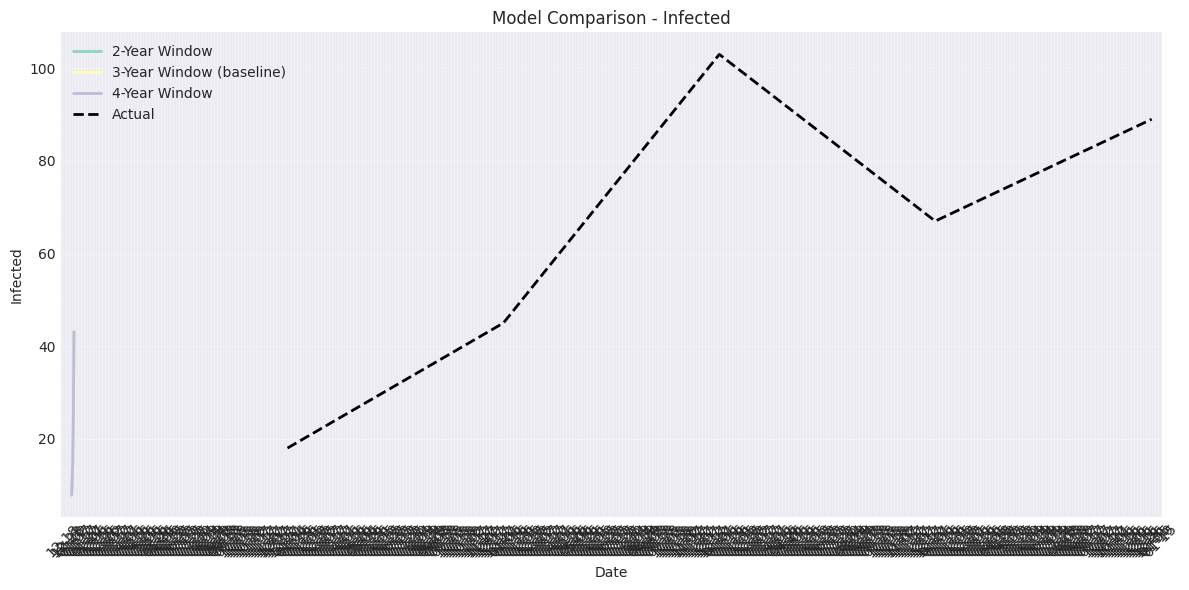


✅ Comparison saved to: notebook_outputs/reporting_demo/model_comparison.png


In [ ]:
# Create alternative model with different smoothing window
container2 = DataContainer(train_data, mode='incidence', window=2)
model2 = Model(container2)
model2.create_model()
model2.fit_model(max_lag=2)
model2.forecast(steps=5)
model2.run_simulations(n_jobs=1)
model2.generate_result()

# Create third model with window=4
container3 = DataContainer(train_data, mode='incidence', window=4)
model3 = Model(container3)
model3.create_model()
model3.fit_model(max_lag=2)
model3.forecast(steps=5)
model3.run_simulations(n_jobs=1)
model3.generate_result()

print("✅ Created 3 models with different smoothing windows")

# Compare models
models = {
    "2-Year Window": model2.results,
    "3-Year Window (baseline)": model.results,
    "4-Year Window": model3.results
}

fig_comparison = create_comparison_report(
    models=models,
    testing_data=test_data,
    compartment='I',
    historical_data=train_data,
    save_path=output_dir / "model_comparison.png"
)

plt.show()

print(f"\n✅ Comparison saved to: {output_dir / 'model_comparison.png'}")

## 10. Quantitative Model Comparison

In [11]:
# Compare evaluation metrics across models
comparison_data = []

for name, results in models.items():
    temp_report = ModelReport(results, test_data, ['I'], name)
    eval_metrics = temp_report.evaluate()['I']['mean']
    
    comparison_data.append({
        'Model': name,
        'MAE': eval_metrics['mae'],
        'RMSE': eval_metrics['rmse'],
        'MAPE (%)': eval_metrics['mape'],
        'SMAPE (%)': eval_metrics['smape']
    })

comparison_df = pd.DataFrame(comparison_data)

print("Model Comparison - Incident Cases (I):")
print("="*80)
display(comparison_df)

# Highlight best model
best_model = comparison_df.loc[comparison_df['MAE'].idxmin()]
print(f"\n🏆 Best performing model: {best_model['Model']}")
print(f"   MAE: {best_model['MAE']:.2f}")
print(f"   RMSE: {best_model['RMSE']:.2f}")

Model Comparison - Incident Cases (I):


,Model,MAE,RMSE,MAPE (%),SMAPE (%)
0,2-Year Window,43.914923,50.576356,66.23544,50.845845
1,3-Year Window (baseline),43.914923,50.576356,66.23544,50.845845
2,4-Year Window,43.914923,50.576356,66.23544,50.845845



🏆 Best performing model: 2-Year Window
   MAE: 43.91
   RMSE: 50.58


## 11. Summary and Best Practices

### What We Learned

1. **ModelReport** provides one-stop reporting for model results
2. **Multiple export formats** support different use cases:
   - Markdown for documentation
   - LaTeX for academic papers
   - High-DPI PNG for publications
3. **Model comparison** tools make it easy to evaluate alternatives
4. **Automated metrics** ensure consistent reporting

### Best Practices for Publications

```python
# For journal submission
report.plot_forecast_panel(
    figsize=(14, 10),
    save_path="manuscript/figure1.png",
    dpi=600  # High resolution
)

# For LaTeX manuscripts
report.export_latex_table("manuscript/table1.tex", "summary")
report.export_latex_table("manuscript/table2.tex", "evaluation")

# For GitHub/documentation
report.export_markdown("docs/results.md")
```

### File Organization

```
project/
├── data/           # Input data
├── notebooks/      # Analysis notebooks
├── outputs/
│   ├── figures/    # PNG files (300-600 DPI)
│   ├── tables/     # LaTeX tables
│   └── reports/    # Markdown reports
└── manuscript/     # Final publication files
```

### Next Steps

- Explore other notebooks for specific use cases
- Read the [Reporting Guide](../../docs/REPORTING_GUIDE.md) for complete API reference
- Check [examples/reporting_example.py](../reporting_example.py) for scripted workflow

## 12. Files Generated

List all files created during this demo

In [12]:
import os

print("Generated files:")
print("="*80)

for file in sorted(output_dir.glob('*')):
    size = os.path.getsize(file)
    if size < 1024:
        size_str = f"{size} B"
    elif size < 1024*1024:
        size_str = f"{size/1024:.1f} KB"
    else:
        size_str = f"{size/(1024*1024):.1f} MB"
    
    print(f"  📄 {file.name:40s} {size_str:>10s}")

print(f"\n📁 Location: {output_dir.absolute()}")
print("\n💡 These files are ready to use in your publications!")

Generated files:
  📄 figure1_forecast.png                       606.1 KB
  📄 measles_report.md                            1.4 KB
  📄 measles_report_forecast.png                631.1 KB
  📄 model_comparison.png                       534.5 KB
  📄 table1_summary.tex                            379 B
  📄 table2_evaluation.tex                         614 B

📁 Location: /workspaces/epydemics.worktrees/improve-report-tools/examples/notebooks/notebook_outputs/reporting_demo

💡 These files are ready to use in your publications!


In [13]:
# Debug: inspect forecast index for 'I' compartment
comp_data_I = model.results['I']
print('Forecast index dtype:', comp_data_I.index.dtype)
print('Unique index count:', len(comp_data_I.index.unique()))
print('First 10 index values:', list(comp_data_I.index)[:10])
print('Has duplicates:', comp_data_I.index.has_duplicates)
print('Min date:', comp_data_I.index.min())
print('Max date:', comp_data_I.index.max())

# Compare with test_data and train_data indices
print('\nTrain index range:', train_data.index.min(), '→', train_data.index.max())
print('Test index range:', test_data.index.min(), '→', test_data.index.max())

Forecast index dtype: datetime64[ns]
Unique index count: 5
First 10 index values: [Timestamp('2020-01-01 00:00:00'), Timestamp('2020-01-02 00:00:00'), Timestamp('2020-01-03 00:00:00'), Timestamp('2020-01-04 00:00:00'), Timestamp('2020-01-05 00:00:00')]
Has duplicates: False
Min date: 2020-01-01 00:00:00
Max date: 2020-01-05 00:00:00

Train index range: 2010-12-31 00:00:00 → 2019-12-31 00:00:00
Test index range: 2020-12-31 00:00:00 → 2024-12-31 00:00:00
